In [1]:
#Packages
!pip install keras
!pip install tensorflow
!pip install unidecode

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import re
from scipy import spatial
from sklearn.manifold import TSNE
import math
import keras
import tensorflow as tf
from unidecode import unidecode
#from keras.preprocessing.text import Tokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 45.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.0/312.0 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 65.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━

2024-04-17 13:23:35.403068: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 13:23:35.409234: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 13:23:35.467720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 13:23:36.421797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
fichier = "data/firstname_with_sex.csv"
name_sex = pd.read_csv(fichier, sep=';')
name_sex

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951
...,...,...,...
6941,winnocq,10,0
6942,xyste,9,1
6943,zara,0,10
6944,zéraphin,10,0


In [3]:
fichier2 = "data/transcriptions_with_sex.csv"
transc = pd.read_csv(fichier2)
transc

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme
...,...,...,...,...
236,1d92738a-cffe-4aee-ab10-db04c37f7405,surname: Burlurut firstname: Pétronille occupa...,nom: Burlurut prénom: Gihromille date_naissanc...,femme
237,09440055-7972-4135-a537-e6c5a1f2aeb2,surname: Combey firstname: Alexandre occupatio...,nom: Comberf prénom: Alexandre date_naissance:...,homme
238,4d387278-12c3-410c-bdf0-c5c603479764,surname: Collin firstname: Marguerite occupati...,nom: Collin prénom: Marguerite date_naissance:...,femme
239,623b95de-f87c-4844-a7f7-361088eed83a,surname: Dumont firstname: Etienne link: fils ...,nom: Dumont prénom: Etienne date_naissance: 19...,homme


In [4]:
transc.loc[0, 'groundtruth']

'surname: Chardon firstname: Marie occupation: idem link: fille age: 30 '

In [5]:
transc.loc[0, 'prediction']

'nom: Chardon prénom: Marie date_naissance: 30 lieux_naissance: " '

In [6]:
transc['sex'].value_counts()

sex
homme     125
femme     107
ambigu      9
Name: count, dtype: int64

In [7]:
element = transc.at[239, 'groundtruth']
element

'surname: Dumont firstname: Etienne link: fils birth_date: 1900 lob: idem '

In [8]:
element = transc.at[201, 'prediction']
element

'nom: d° prénom: Arthur date_naissance: 2 lieux_naissance: Sp relation: F '

In [9]:
#Convert in character
transc['groundtruth'] = transc['groundtruth'].astype(str)

#We divide by ":"
split = transc['groundtruth'].str.split(":", expand=True)
split

,0,1,2,3,4,5,6,7
0,surname,Chardon firstname,Marie occupation,idem link,fille age,30,None,None
1,surname,Lhopital firstname,Louis-Jean occupation,sp link,chef age,67,None,None
2,surname,Papin firstname,Marie occupation,idem link,idem employer,idem age,15,None
3,surname,Lavocat firstname,Marie link,femme birth_date,1875 lob,Rigny,None,None
4,surname,Benne firstname,Marguerite age,78,None,None,None,None
...,...,...,...,...,...,...,...,...
236,surname,Burlurut firstname,Pétronille occupation,sans profession link,épouse age,61 ans,None,None
237,surname,Combey firstname,Alexandre occupation,idem link,son fils age,39,None,None
238,surname,Collin firstname,Marguerite occupation,idem link,épouse employer,idem age,38,None
239,surname,Dumont firstname,Etienne link,fils birth_date,1900 lob,idem,None,None


I extract column by taking the last words of the column above. I just don't take the last column because it's a value and not the name of a category. 

In [10]:
categories = []

for k in range(8):
    # Check if columns are eùpty after column k
    if all(split.iloc[:, j].isnull().all() for j in range(k + 1, 8)):
        break
    
    # If not, add element in the list of categories if it's not already in
    categories += split[k].str.split().str[-1][split.iloc[:, k:].notnull().all(axis=1)].unique().tolist()

categories

['surname',
 'firstname',
 'occupation',
 'link',
 'employer',
 'birth_date',
 'age',
 'lob',
 'civil_status']

In [11]:
#List of columns
colonnes = ['surname', 'firstname', 'occupation', 'link', 'employer', 'birth_date', 'age', 'lob', 'civil_status', 'observation'] #I add observation because it was printed as error. 

#Creation of a dictionary
donnees = {colonne: [] for colonne in colonnes}

#Fill the dictionnary with the elements
for row in transc['groundtruth']:
    #Empty temporary dict in initialisation 
    temp = {colonne: None for colonne in colonnes}
    #Thanks to RegEx, we take expressop,s
    info = re.findall(r'(\w+): (\w+)', row)
    for colonne, valeur in info:
        # We add the corresponding value 
        temp[colonne] = valeur
    #Definitive dict
    for colonne in colonnes:
        donnees[colonne].append(temp[colonne])

# Créer un DataFrame à partir des données extraites
nouvelle_base_man = pd.DataFrame(donnees)
nouvelle_base_man

,surname,firstname,occupation,link,employer,birth_date,age,lob,civil_status,observation
0,Chardon,Marie,idem,fille,None,None,30,None,None,None
1,Lhopital,Louis,sp,chef,None,None,67,None,None,None
2,Papin,Marie,idem,idem,idem,None,15,None,None,None
3,Lavocat,Marie,None,femme,None,1875,None,Rigny,None,None
4,Benne,Marguerite,None,None,None,None,78,None,None,None
...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans,épouse,None,None,61,None,None,None
237,Combey,Alexandre,idem,son,None,None,39,None,None,None
238,Collin,Marguerite,idem,épouse,idem,None,38,None,None,None
239,Dumont,Etienne,None,fils,None,1900,None,idem,None,None


In [12]:
#We do the same for prediction column 
#Convert in character
transc['prediction'] = transc['prediction'].astype(str)

#We divide by ":"
split = transc['prediction'].str.split(":", expand=True)
split

,0,1,2,3,4,5,6,7,8,9
0,nom,Chardon prénom,Marie date_naissance,30 lieux_naissance,"""",None,None,None,None,None
1,nom,Lhopital prénom,Louis Jean date_naissance,67 lieux_naissance,Sn employeur,ahef,None,None,None,None
2,nom,Pyrin prénom,Marie date_naissance,55 relation,d,None,None,None,None,None
3,nom,Lavocat prénom,Marie date_naissance,1875 lieux_naissance,Rigny profession,'',None,None,None,None
4,nom,Benne prénom,Marguerite date_naissance,78 lieux_naissance,id relation,'',None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
236,nom,Burlurut prénom,Gihromille date_naissance,61 lieux_naissance,épouse relation,sans mof,None,None,None,None
237,nom,Comberf prénom,Alexandre date_naissance,59 lieux_naissance,d relation,par profession,fils,None,None,None
238,nom,Collin prénom,Marguerite date_naissance,38 profession,femme profession,patron,None,None,None,None
239,nom,Dumont prénom,Etienne date_naissance,1900 lieux_naissance,id,None,None,None,None,None


In [13]:
categories = []

for k in range(9):
    # Check if columns are eùpty after column k
    if all(split.iloc[:, j].isnull().all() for j in range(k + 1, 8)):
        break
    
    # If not, add element in the list of categories if it's not already in
    categories += split[k].str.split().str[-1][split.iloc[:, k:].notnull().all(axis=1)].unique().tolist()

categories

['nom',
 'prénom',
 'date_naissance',
 'lieux_naissance',
 'relation',
 'employeur',
 'prénom']

In [14]:
#List of columns
colonnes = ['nom', 'prénom', 'date_naissance', 'lieux_naissance', 'relation', 'employeur'] #Prénom apperaed twice in categories 
#Creation of a dictionary
donnees = {colonne: [] for colonne in colonnes}

#Fill the dictionnary with the elements
for row in transc['prediction']:
    # Initialiser un dictionnaire temporaire pour stocker les informations extraites de chaque ligne
    temp = {colonne: None for colonne in colonnes}
    # Extraire les informations de chaque ligne en utilisant des expressions régulières
    info = re.findall(r'(\w+): (\w+)', row)
    # Parcourir les informations extraites
    for colonne, valeur in info:
        # Ajouter la valeur à la colonne temporaire correspondante
        temp[colonne] = valeur
    # Ajouter les valeurs du dictionnaire temporaire au dictionnaire de données
    for colonne in colonnes:
        donnees[colonne].append(temp[colonne])

# Créer un DataFrame à partir des données extraites
nouvelle_base_aut = pd.DataFrame(donnees)


In [15]:
#Add ID to both database
nouvelle_base_aut['subject_line'] = transc['subject_line']
nouvelle_base_man['subject_line'] = transc['subject_line']
nouvelle_base_man

,surname,firstname,occupation,link,employer,birth_date,age,lob,civil_status,observation,subject_line
0,Chardon,Marie,idem,fille,None,None,30,None,None,None,ebb26ada-044c-4c62-9dbc-a9c8d505d31c
1,Lhopital,Louis,sp,chef,None,None,67,None,None,None,338496f5-e4ca-43ac-aa5c-429cb3f6ac00
2,Papin,Marie,idem,idem,idem,None,15,None,None,None,e6a279da-9b6f-4f49-b498-64857bc50d1e
3,Lavocat,Marie,None,femme,None,1875,None,Rigny,None,None,7534deca-39e8-4f00-be17-c12460015de1
4,Benne,Marguerite,None,None,None,None,78,None,None,None,ef334a66-a504-418a-9872-e7c9db923488
...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans,épouse,None,None,61,None,None,None,1d92738a-cffe-4aee-ab10-db04c37f7405
237,Combey,Alexandre,idem,son,None,None,39,None,None,None,09440055-7972-4135-a537-e6c5a1f2aeb2
238,Collin,Marguerite,idem,épouse,idem,None,38,None,None,None,4d387278-12c3-410c-bdf0-c5c603479764
239,Dumont,Etienne,None,fils,None,1900,None,idem,None,None,623b95de-f87c-4844-a7f7-361088eed83a


In [16]:
#We will merge data base
data =  pd.merge(nouvelle_base_aut, nouvelle_base_man , how='left', on = 'subject_line')
df = pd.merge(data, transc, how = 'left', on = 'subject_line')
df_def = df.drop(['groundtruth', 'prediction'], axis = 1)
df_def

,nom,prénom,date_naissance,lieux_naissance,relation,employeur,subject_line,surname,firstname,occupation,link,employer,birth_date,age,lob,civil_status,observation,sex
0,Chardon,Marie,30,None,None,None,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,Chardon,Marie,idem,fille,None,None,30,None,None,None,femme
1,Lhopital,Louis,67,Sn,None,ahef,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,Lhopital,Louis,sp,chef,None,None,67,None,None,None,homme
2,Pyrin,Marie,55,None,d,None,e6a279da-9b6f-4f49-b498-64857bc50d1e,Papin,Marie,idem,idem,idem,None,15,None,None,None,femme
3,Lavocat,Marie,1875,Rigny,None,None,7534deca-39e8-4f00-be17-c12460015de1,Lavocat,Marie,None,femme,None,1875,None,Rigny,None,None,femme
4,Benne,Marguerite,78,id,None,None,ef334a66-a504-418a-9872-e7c9db923488,Benne,Marguerite,None,None,None,None,78,None,None,None,femme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Gihromille,61,épouse,sans,None,1d92738a-cffe-4aee-ab10-db04c37f7405,Burlurut,Pétronille,sans,épouse,None,None,61,None,None,None,femme
237,Comberf,Alexandre,59,d,par,None,09440055-7972-4135-a537-e6c5a1f2aeb2,Combey,Alexandre,idem,son,None,None,39,None,None,None,homme
238,Collin,Marguerite,38,None,None,None,4d387278-12c3-410c-bdf0-c5c603479764,Collin,Marguerite,idem,épouse,idem,None,38,None,None,None,femme
239,Dumont,Etienne,1900,id,None,None,623b95de-f87c-4844-a7f7-361088eed83a,Dumont,Etienne,None,fils,None,1900,None,idem,None,None,homme


Now, using the database about the name and the number of times they were gave to each sex, we will calculus a man proportion and a woman proportion for each name and add it to our current database. 

In [17]:
#Calculus
name_sex['prob_masc'] = name_sex['male'] / (name_sex['male'] + name_sex['female'])
name_sex['prob_fem'] = name_sex['female'] / (name_sex['male'] + name_sex['female'])
name_sex.head(50)

,firstname,male,female,prob_masc,prob_fem
0,marie,10145,2390322,0.004226,0.995774
1,jean,1869615,6476,0.996548,0.003452
2,pierre,1475841,5047,0.996592,0.003408
3,jeanne,1765,1097397,0.001606,0.998394
4,françois,1089009,5951,0.994565,0.005435
5,joseph,897742,4246,0.995293,0.004707
6,anne,1479,816241,0.001809,0.998191
7,marguerite,1441,813859,0.001767,0.998233
8,catherine,1223,792448,0.001541,0.998459
9,louis,750498,2720,0.996389,0.003611


In [46]:
def label_sex(prob_m, prob_f):
    if prob_m>=0.95:
        return 'homme'
    if prob_f>=0.95:
        return 'femme'
    else:
        return 'ambigu'

name_sex['sex'] = name_sex.apply(lambda row: label_sex(row['prob_masc'], row['prob_fem']), axis=1)
name_sex

,firstname,male,female,prob_masc,prob_fem,sex
0,marie,10145,2390322,0.004226,0.995774,femme
1,jean,1869615,6476,0.996548,0.003452,homme
2,pierre,1475841,5047,0.996592,0.003408,homme
3,jeanne,1765,1097397,0.001606,0.998394,femme
4,francois,1089009,5951,0.994565,0.005435,homme
...,...,...,...,...,...,...
6941,winnocq,10,0,1.000000,0.000000,homme
6942,xyste,9,1,0.900000,0.100000,ambigu
6943,zara,0,10,0.000000,1.000000,femme
6944,zeraphin,10,0,1.000000,0.000000,homme


In [22]:
#We convert firstname in both column without accent and capital letters (We choose first name because we trust more manual recolt) 
name_sex['firstname'] = name_sex['firstname'].astype(str)
name_sex['firstname'] = name_sex['firstname'].apply(lambda x: unidecode(x).lower()) 
df_def['firstname'] = df_def['firstname'].apply(lambda x: unidecode(x).lower() if pd.notna(x) else x)
df_def

,nom,prénom,date_naissance,lieux_naissance,relation,employeur,subject_line,surname,firstname,occupation,link,employer,birth_date,age,lob,civil_status,observation,sex,prob_masc,prob_fem
0,Chardon,Marie,30,None,None,None,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,Chardon,marie,idem,fille,None,None,30,None,None,None,femme,0.004226,0.995774
1,Lhopital,Louis,67,Sn,None,ahef,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,Lhopital,louis,sp,chef,None,None,67,None,None,None,homme,0.996389,0.003611
2,Pyrin,Marie,55,None,d,None,e6a279da-9b6f-4f49-b498-64857bc50d1e,Papin,marie,idem,idem,idem,None,15,None,None,None,femme,0.004226,0.995774
3,Lavocat,Marie,1875,Rigny,None,None,7534deca-39e8-4f00-be17-c12460015de1,Lavocat,marie,None,femme,None,1875,None,Rigny,None,None,femme,0.004226,0.995774
4,Benne,Marguerite,78,id,None,None,ef334a66-a504-418a-9872-e7c9db923488,Benne,marguerite,None,None,None,None,78,None,None,None,femme,0.001767,0.998233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Gihromille,61,épouse,sans,None,1d92738a-cffe-4aee-ab10-db04c37f7405,Burlurut,petronille,sans,épouse,None,None,61,None,None,None,femme,0.002291,0.997709
237,Comberf,Alexandre,59,d,par,None,09440055-7972-4135-a537-e6c5a1f2aeb2,Combey,alexandre,idem,son,None,None,39,None,None,None,homme,0.995444,0.004556
238,Collin,Marguerite,38,None,None,None,4d387278-12c3-410c-bdf0-c5c603479764,Collin,marguerite,idem,épouse,idem,None,38,None,None,None,femme,0.001767,0.998233
239,Dumont,Etienne,1900,id,None,None,623b95de-f87c-4844-a7f7-361088eed83a,Dumont,etienne,None,fils,None,1900,None,idem,None,None,homme,0.995768,0.004232


In [32]:
name_sex_unique = name_sex.drop_duplicates(subset=['firstname'])
probabilities = name_sex_unique.set_index('firstname').to_dict(orient='index')

# We assocy each probability with map
df_def['prob_masc'] = df_def['firstname'].map(lambda x: probabilities[x]['prob_masc'] if x in probabilities else None)
df_def['prob_fem'] = df_def['firstname'].map(lambda x: probabilities[x]['prob_fem'] if x in probabilities else None)

In [33]:
df_def

,nom,prénom,date_naissance,lieux_naissance,relation,employeur,subject_line,surname,firstname,occupation,link,employer,birth_date,age,lob,civil_status,observation,sex,prob_masc,prob_fem
0,Chardon,Marie,30,None,None,None,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,Chardon,marie,idem,fille,None,None,30,None,None,None,femme,0.004226,0.995774
1,Lhopital,Louis,67,Sn,None,ahef,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,Lhopital,louis,sp,chef,None,None,67,None,None,None,homme,0.996389,0.003611
2,Pyrin,Marie,55,None,d,None,e6a279da-9b6f-4f49-b498-64857bc50d1e,Papin,marie,idem,idem,idem,None,15,None,None,None,femme,0.004226,0.995774
3,Lavocat,Marie,1875,Rigny,None,None,7534deca-39e8-4f00-be17-c12460015de1,Lavocat,marie,None,femme,None,1875,None,Rigny,None,None,femme,0.004226,0.995774
4,Benne,Marguerite,78,id,None,None,ef334a66-a504-418a-9872-e7c9db923488,Benne,marguerite,None,None,None,None,78,None,None,None,femme,0.001767,0.998233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Gihromille,61,épouse,sans,None,1d92738a-cffe-4aee-ab10-db04c37f7405,Burlurut,petronille,sans,épouse,None,None,61,None,None,None,femme,0.002291,0.997709
237,Comberf,Alexandre,59,d,par,None,09440055-7972-4135-a537-e6c5a1f2aeb2,Combey,alexandre,idem,son,None,None,39,None,None,None,homme,0.995444,0.004556
238,Collin,Marguerite,38,None,None,None,4d387278-12c3-410c-bdf0-c5c603479764,Collin,marguerite,idem,épouse,idem,None,38,None,None,None,femme,0.001767,0.998233
239,Dumont,Etienne,1900,id,None,None,623b95de-f87c-4844-a7f7-361088eed83a,Dumont,etienne,None,fils,None,1900,None,idem,None,None,homme,0.995768,0.004232


In [35]:
df = df_def.drop(['nom', 'surname', 'date_naissance', 'lieux_naissance',  'subject_line','birth_date', 'age', 'lob'], axis=1)

,prénom,relation,employeur,firstname,occupation,link,employer,civil_status,observation,sex,prob_masc,prob_fem
0,Marie,None,None,marie,idem,fille,None,None,None,femme,0.004226,0.995774
1,Louis,None,ahef,louis,sp,chef,None,None,None,homme,0.996389,0.003611
2,Marie,d,None,marie,idem,idem,idem,None,None,femme,0.004226,0.995774
3,Marie,None,None,marie,None,femme,None,None,None,femme,0.004226,0.995774
4,Marguerite,None,None,marguerite,None,None,None,None,None,femme,0.001767,0.998233
...,...,...,...,...,...,...,...,...,...,...,...,...
236,Gihromille,sans,None,petronille,sans,épouse,None,None,None,femme,0.002291,0.997709
237,Alexandre,par,None,alexandre,idem,son,None,None,None,homme,0.995444,0.004556
238,Marguerite,None,None,marguerite,idem,épouse,idem,None,None,femme,0.001767,0.998233
239,Etienne,None,None,etienne,None,fils,None,None,None,homme,0.995768,0.004232


In [36]:
name_sex

,firstname,male,female,prob_masc,prob_fem,label
0,marie,10145,2390322,0.004226,0.995774,femme
1,jean,1869615,6476,0.996548,0.003452,homme
2,pierre,1475841,5047,0.996592,0.003408,homme
3,jeanne,1765,1097397,0.001606,0.998394,femme
4,francois,1089009,5951,0.994565,0.005435,homme
...,...,...,...,...,...,...
6941,winnocq,10,0,1.000000,0.000000,homme
6942,xyste,9,1,0.900000,0.100000,ambigu
6943,zara,0,10,0.000000,1.000000,femme
6944,zeraphin,10,0,1.000000,0.000000,homme


In [47]:
#We add the value of names that are not in firstname 
name_sex_joint = name_sex.drop(['male', 'female'], axis=1)

common_cols = df.columns.intersection(name_sex_joint.columns)
extra_cols = name_sex_joint.columns.difference(df.columns)
extra_df = pd.DataFrame(None, index=name_sex_joint.index, columns=extra_cols)

# Filtrer les lignes de name_sex où 'firstname' n'existe pas déjà dans df
filtered_name_sex = name_sex_joint[~name_sex_joint['firstname'].isin(df['firstname'])]

# Concaténer les DataFrames filtered_name_sex et merged_df
final_df = pd.concat([filtered_name_sex, df])

# Réinitialiser les index
final_df.reset_index(drop=True, inplace=True)

final_df

,firstname,prob_masc,prob_fem,sex,prénom,relation,employeur,occupation,link,employer,civil_status,observation
0,michel,0.996127,0.003873,homme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,guillaume,0.996009,0.003991,homme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,yves,0.996545,0.003455,homme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,julien,0.995715,0.004285,homme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,marianne,0.002083,0.997917,femme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7034,petronille,0.002291,0.997709,femme,Gihromille,sans,None,sans,épouse,None,None,None
7035,alexandre,0.995444,0.004556,homme,Alexandre,par,None,idem,son,None,None,None
7036,marguerite,0.001767,0.998233,femme,Marguerite,None,None,idem,épouse,idem,None,None
7037,etienne,0.995768,0.004232,homme,Etienne,None,None,None,fils,None,None,None


In [49]:
#We remove ambiguous sex
df2 = final_df[final_df['sex'] != 'ambigu']

In [50]:
for colonne in df2.columns:
     df2[colonne] = df2[colonne].apply(lambda x: unidecode(x).lower() if isinstance(x, str) else x) #convert all in lower character to avoid differences by letter case

df2 = df2.drop(['prénom', 'relation', 'employeur'], axis=1)
df2

/tmp/ipykernel_262/3821979482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[colonne] = df2[colonne].apply(lambda x: unidecode(x).lower() if isinstance(x, str) else x) #convert all in lower character to avoid differences by letter case


,firstname,prob_masc,prob_fem,sex,occupation,link,employer,civil_status,observation
0,michel,0.996127,0.003873,homme,NaN,NaN,NaN,NaN,NaN
1,guillaume,0.996009,0.003991,homme,NaN,NaN,NaN,NaN,NaN
2,yves,0.996545,0.003455,homme,NaN,NaN,NaN,NaN,NaN
3,julien,0.995715,0.004285,homme,NaN,NaN,NaN,NaN,NaN
4,marianne,0.002083,0.997917,femme,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
7034,petronille,0.002291,0.997709,femme,sans,epouse,None,None,None
7035,alexandre,0.995444,0.004556,homme,idem,son,None,None,None
7036,marguerite,0.001767,0.998233,femme,idem,epouse,idem,None,None
7037,etienne,0.995768,0.004232,homme,None,fils,None,None,None


In [51]:
df2.to_csv('data/base.csv', index=False)

In [52]:
df = pd.read_csv('data/base.csv')
df

,firstname,prob_masc,prob_fem,sex,occupation,link,employer,civil_status,observation
0,michel,0.996127,0.003873,homme,NaN,NaN,NaN,NaN,NaN
1,guillaume,0.996009,0.003991,homme,NaN,NaN,NaN,NaN,NaN
2,yves,0.996545,0.003455,homme,NaN,NaN,NaN,NaN,NaN
3,julien,0.995715,0.004285,homme,NaN,NaN,NaN,NaN,NaN
4,marianne,0.002083,0.997917,femme,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6028,petronille,0.002291,0.997709,femme,sans,epouse,NaN,NaN,NaN
6029,alexandre,0.995444,0.004556,homme,idem,son,NaN,NaN,NaN
6030,marguerite,0.001767,0.998233,femme,idem,epouse,idem,NaN,NaN
6031,etienne,0.995768,0.004232,homme,NaN,fils,NaN,NaN,NaN


In [53]:
df.columns

Index(['firstname', 'prob_masc', 'prob_fem', 'sex', 'occupation', 'link',
       'employer', 'civil_status', 'observation'],
      dtype='object')

In [54]:
# Liste des colonnes textuelles que vous souhaitez concaténer
colonnes_a_concatener = ['firstname', 'occupation', 'link',
       'employer', 'civil_status', 'observation']

# Créez une nouvelle colonne 'text_combined' qui concatène les valeurs de toutes les colonnes textuelles
df['text_combined'] = df.apply(lambda row: ' '.join(row[col] for col in colonnes_a_concatener if pd.notna(row[col])), axis=1)
df

,firstname,prob_masc,prob_fem,sex,occupation,link,employer,civil_status,observation,text_combined
0,michel,0.996127,0.003873,homme,NaN,NaN,NaN,NaN,NaN,michel
1,guillaume,0.996009,0.003991,homme,NaN,NaN,NaN,NaN,NaN,guillaume
2,yves,0.996545,0.003455,homme,NaN,NaN,NaN,NaN,NaN,yves
3,julien,0.995715,0.004285,homme,NaN,NaN,NaN,NaN,NaN,julien
4,marianne,0.002083,0.997917,femme,NaN,NaN,NaN,NaN,NaN,marianne
...,...,...,...,...,...,...,...,...,...,...
6028,petronille,0.002291,0.997709,femme,sans,epouse,NaN,NaN,NaN,petronille sans epouse
6029,alexandre,0.995444,0.004556,homme,idem,son,NaN,NaN,NaN,alexandre idem son
6030,marguerite,0.001767,0.998233,femme,idem,epouse,idem,NaN,NaN,marguerite idem epouse idem
6031,etienne,0.995768,0.004232,homme,NaN,fils,NaN,NaN,NaN,etienne fils


In [82]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df[['prob_masc', 'prob_fem', 'text_combined']]
y = df['sex']
        
# Créez un pipeline pour les colonnes textuelles
text_transformer = Pipeline(steps=[
    ('vectorizer', CountVectorizer())  # Vous pouvez spécifier d'autres paramètres de CountVectorizer selon vos besoins
])



ValueError: Found input variables with inconsistent numbers of samples: [1, 185]

In [55]:
df['prof_hf'] = df['prob_masc'] - df['prob_fem']
df
#The idea is that: if the value is near 1, it's masculine. If it's near -1, it's feminine. Near 0, it's ambiguous 

,firstname,prob_masc,prob_fem,sex,occupation,link,employer,civil_status,observation,text_combined,prof_hf
0,michel,0.996127,0.003873,homme,NaN,NaN,NaN,NaN,NaN,michel,0.992253
1,guillaume,0.996009,0.003991,homme,NaN,NaN,NaN,NaN,NaN,guillaume,0.992017
2,yves,0.996545,0.003455,homme,NaN,NaN,NaN,NaN,NaN,yves,0.993090
3,julien,0.995715,0.004285,homme,NaN,NaN,NaN,NaN,NaN,julien,0.991429
4,marianne,0.002083,0.997917,femme,NaN,NaN,NaN,NaN,NaN,marianne,-0.995833
...,...,...,...,...,...,...,...,...,...,...,...
6028,petronille,0.002291,0.997709,femme,sans,epouse,NaN,NaN,NaN,petronille sans epouse,-0.995419
6029,alexandre,0.995444,0.004556,homme,idem,son,NaN,NaN,NaN,alexandre idem son,0.990888
6030,marguerite,0.001767,0.998233,femme,idem,epouse,idem,NaN,NaN,marguerite idem epouse idem,-0.996465
6031,etienne,0.995768,0.004232,homme,NaN,fils,NaN,NaN,NaN,etienne fils,0.991536


In [57]:
df_model = df.dropna(subset=['prof_hf'])
df_model['sex'] = df_model['sex'].replace({'homme': 1, 'femme': -1})
df_model

/tmp/ipykernel_262/3043037105.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['sex'] = df_model['sex'].replace({'homme': 1, 'femme': -1})
/tmp/ipykernel_262/3043037105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['sex'] = df_model['sex'].replace({'homme': 1, 'femme': -1})


,firstname,prob_masc,prob_fem,sex,occupation,link,employer,civil_status,observation,text_combined,prof_hf
0,michel,0.996127,0.003873,1,NaN,NaN,NaN,NaN,NaN,michel,0.992253
1,guillaume,0.996009,0.003991,1,NaN,NaN,NaN,NaN,NaN,guillaume,0.992017
2,yves,0.996545,0.003455,1,NaN,NaN,NaN,NaN,NaN,yves,0.993090
3,julien,0.995715,0.004285,1,NaN,NaN,NaN,NaN,NaN,julien,0.991429
4,marianne,0.002083,0.997917,-1,NaN,NaN,NaN,NaN,NaN,marianne,-0.995833
...,...,...,...,...,...,...,...,...,...,...,...
6028,petronille,0.002291,0.997709,-1,sans,epouse,NaN,NaN,NaN,petronille sans epouse,-0.995419
6029,alexandre,0.995444,0.004556,1,idem,son,NaN,NaN,NaN,alexandre idem son,0.990888
6030,marguerite,0.001767,0.998233,-1,idem,epouse,idem,NaN,NaN,marguerite idem epouse idem,-0.996465
6031,etienne,0.995768,0.004232,1,NaN,fils,NaN,NaN,NaN,etienne fils,0.991536


In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Séparez les caractéristiques (X) et les étiquettes (y)
X = df_model[['prof_hf']] # Caractéristique
y = df_model['sex']  # Étiquette

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créez et entraînez un modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédisez les étiquettes sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluez les performances du modèle
# Si vous voulez utiliser une certaine tolérance autour de 0 pour prédire le label, vous pouvez définir une fonction comme suit :
#Le problème est qu'on s'autodémontre vu la manière dont on a construit les labels sur les prénoms pour ceux dans la base name_sex
def predict_gender(y):
    if y < -0.91:
        return -1
    elif y > 0.91:
        return 1
    else:
        return 0

y_pred_labels = [predict_gender(y) for y in y_pred]

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)
y_pred


Accuracy: 0.9983416252072969


array([-1.0069498 ,  1.00245001,  0.99906232, ..., -1.0069498 ,
        0.98185219,  1.00285956])

In [78]:
#We will create a database with some characteristics about names. 
# Nombre de lettres
df['firstname'] = df['firstname'].astype(str)

df['nb_lt'] = df['firstname'].apply(lambda x: len(x))
df['last_lt'] = df['firstname'].str[-1]
df['2last_lt'] = df['firstname'].str[-2:]
df['3last_lt'] = df['firstname'].str[-3:]

df

,firstname,prob_masc,prob_fem,sex,occupation,link,employer,civil_status,observation,text_combined,prof_hf,nb_lt,last_lt,2last_lt,3last_lt
0,michel,0.996127,0.003873,homme,NaN,NaN,NaN,NaN,NaN,michel,0.992253,6,l,el,hel
1,guillaume,0.996009,0.003991,homme,NaN,NaN,NaN,NaN,NaN,guillaume,0.992017,9,e,me,ume
2,yves,0.996545,0.003455,homme,NaN,NaN,NaN,NaN,NaN,yves,0.993090,4,s,es,ves
3,julien,0.995715,0.004285,homme,NaN,NaN,NaN,NaN,NaN,julien,0.991429,6,n,en,ien
4,marianne,0.002083,0.997917,femme,NaN,NaN,NaN,NaN,NaN,marianne,-0.995833,8,e,ne,nne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6028,petronille,0.002291,0.997709,femme,sans,epouse,NaN,NaN,NaN,petronille sans epouse,-0.995419,10,e,le,lle
6029,alexandre,0.995444,0.004556,homme,idem,son,NaN,NaN,NaN,alexandre idem son,0.990888,9,e,re,dre
6030,marguerite,0.001767,0.998233,femme,idem,epouse,idem,NaN,NaN,marguerite idem epouse idem,-0.996465,10,e,te,ite
6031,etienne,0.995768,0.004232,homme,NaN,fils,NaN,NaN,NaN,etienne fils,0.991536,7,e,ne,nne


/tmp/ipykernel_262/4200169966.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['sex'] = df_model['sex'].replace({'homme': 1, 'femme': -1})
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 1.00



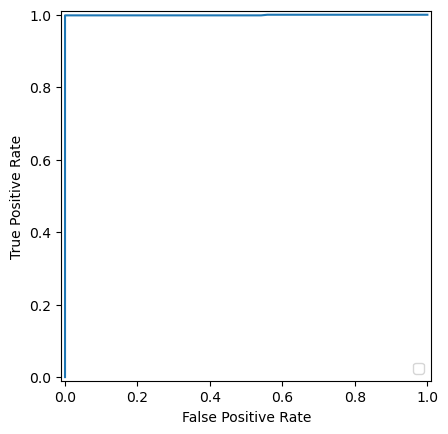

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score,roc_curve,ConfusionMatrixDisplay,RocCurveDisplay

df_model['sex'] = df_model['sex'].replace({'homme': 1, 'femme': -1})
df_model = df.drop(['firstname','occupation', 'link', 'employer', 'civil_status', 'observation', 'text_combined', 'prob_masc', 'prob_fem'], axis =1)
df_model = pd.get_dummies(df_model, columns=['nb_lt', 'last_lt', '2last_lt', '3last_lt'])
df_model = df_model.dropna()
X = df_model.drop(columns=['sex'])
y = df_model['sex']

#Split the data into a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Create a Logistic Regression with the parameters found on Dataiku

model = LogisticRegression(penalty='l2', C=1, solver='saga')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}\n')

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the confusion matrix
#cm = confusion_matrix(y_test, y_pred, normalize='true',labels=[1,2])
#print(f'Confusion matrix:\n {cm}\n')

#cm_display = ConfusionMatrixDisplay(cm,display_labels=[1,2]).plot()

y_score = model.decision_function(X_test)
# Calculate the true positive rate and false positive rate for a range of thresholds
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])

# Plot the ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [86]:
#We will reduce dimensionality in order to limit difficulties 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_pca = df_model.drop(['sex', 'prof_hf'], axis=1)

# Standardiser les données
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_pca)

# Appliquer l'analyse en composantes principales (PCA) sans spécifier le nombre de composantes
pca = PCA()  
pca_result = pca.fit_transform(scaled_df)

# Afficher les dimensions des composantes principales
print("Nombre de composantes principales:", pca.n_components_)

# Afficher la variance expliquée par chaque composante principale
print("Variance expliquée par chaque composante principale:", pca.explained_variance_ratio_)

# Afficher la variance expliquée cumulée
print("Variance expliquée cumulée:", pca.explained_variance_ratio_.cumsum())

Nombre de composantes principales: 1186
Variance expliquée par chaque composante principale: [3.14275117e-03 2.73715008e-03 2.73421220e-03 ... 3.27084576e-37
 1.96181077e-37 1.34314937e-38]
Variance expliquée cumulée: [0.00314275 0.0058799  0.00861411 ... 1.         1.         1.        ]


array([[-0.01821044, -0.02575772, -0.11143694, ..., -0.01287566,
        -0.02230499, -0.01287566],
       [-0.01821044, -0.02575772, -0.11143694, ..., -0.01287566,
        -0.02230499, -0.01287566],
       [-0.01821044, -0.02575772, -0.11143694, ..., -0.01287566,
        -0.02230499, -0.01287566],
       ...,
       [-0.01821044, -0.02575772, -0.11143694, ..., -0.01287566,
        -0.02230499, -0.01287566],
       [-0.01821044, -0.02575772, -0.11143694, ..., -0.01287566,
        -0.02230499, -0.01287566],
       [-0.01821044, -0.02575772, -0.11143694, ..., -0.01287566,
        -0.02230499, -0.01287566]])

In [ ]:
embed_size = 128
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           input_shape=[None]),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
history = model.fit(X_train, epochs=5)

In [31]:
#Implementation of neural net
model = Sequential()
model.add(layers.Dense(units=3, input_shape=[15]))
model.add(layers.Dense(units=64))
model.add(layers.Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x=x, y=y, epochs=500)

#model.predict